In [8]:
import pandas as pd

import argparse
from time import time
import matplotlib.pyplot as plt

from datasets import load_from_disk
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments
from utils_dev import *

from concrete.ml.torch.hybrid_model import HybridFHEMode
from concrete.ml.torch.lora import LoraTrainer

/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/.venv_llama/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hybrid Fine-Tuning of LLaMA with LoRA

This notebook showcases how to fine-tune the LLaMA-3.2-1B model using LoRA (Low-Rank Adaptation) on the Orca Math Word Problems dataset. The fine-tuning is performed using the _HybridModel_ paradigm, which enables a seamless separation of the computational workload of large language models between the client and a remote server.

To preserve data privacy while maintaining performance, this hybrid setup leverages Fully Homomorphic Encryption (FHE) on the remote side. The execution pipeline is structured as follows:

- Remote linear layers — which account for the majority of the model's weights and computational cost — are offloaded to a distant machine and executed under encryption using FHE.
- Local non-linear layers — such as activation functions — are retained on-premise and executed in plaintext on the client side.
- The client’s dataset remains strictly local and is never transferred externally.

This approach allows for privacy-preserving fine-tuning and inference, while reducing the computational burden on the client and ensuring that sensitive data never leaves the local environment.

In [9]:
PEFT_ARGS = {
    "r": 8,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
    "bias": "none",
    "task_type": "CAUSAL_LM",
    "target_modules": "all-linear",
}

TRAINING_ARGS = {
    "output_dir": "./checkpoints",
    "num_train_epochs": 1,
    "per_device_train_batch_size": 1,
    "gradient_accumulation_steps": 1,
    "save_total_limit": 1,
    "use_cpu": True,
    "learning_rate": 2e-4,
    "lr_scheduler_type": "linear",
    "seed": SEED,
    "data_seed": SEED,
    "warmup_steps": 10,
    "weight_decay": 0.01,
    "prediction_loss_only": True,
    "report_to": "none",
}

URL = "http://15.237.83.254:8001"
MACHINE = "M4"
DEVICE = get_device(force_device='cpu')

## Load data

The question-answer dataset has been preprocessed and filtered in the `processed_data.py` script and saved to disk for convenience. We load it here directly to simplify the fine-tuning workflow.

> ⚠️ If the files are missing, please run `processed_data.py` to regenerate them.


In [4]:
collator = DataCollator(TOKENIZER)
train_dataset = load_from_disk(TRAIN_PATH)
test_dataset = load_from_disk(TEST_PATH)

In [ ]:




def initialize_model(seed=SEED):
    """Initialize the model with consistent weights."""
    set_seed(seed)

    # Load the LLaMA model and tokenizer, and test the base model output.
    pretrained_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, token=HF_TOKEN).to(DEVICE)
    pretrained_model.config.pad_token_id = pretrained_model.config.eos_token_id

    for param in pretrained_model.parameters():
        param.requires_grad = False

    PROMPT = "When you multiply a number by 7, it becomes 98. What is that number?\n"
    _ = generate_and_print(PROMPT, pretrained_model, TOKENIZER, seed=SEED)

    # Set up LoRA parameters and apply them to the model.
    peft_model = get_peft_model(pretrained_model, LoraConfig(**PEFT_ARGS)).to(DEVICE)

    # Configure the training hyperparameters.
    hf_trainer = Trainer(
        model=peft_model,
        args=TrainingArguments(**TRAINING_ARGS),
        train_dataset=train_dataset,
        data_collator=collator,
    )

    train_dl = hf_trainer.get_train_dataloader()
    eval_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

    hf_trainer.create_optimizer_and_scheduler(len(train_dl) * TRAINING_ARGS["num_train_epochs"])
    optimizer, lr_scheduler = hf_trainer.optimizer, hf_trainer.lr_scheduler

    lora_trainer = LoraTrainer(
        model=peft_model,
        optimizer=optimizer,
        loss_fn=causal_lm_loss,
        lr_scheduler=lr_scheduler,
        training_args=TRAINING_ARGS,
        n_layers_to_skip_for_backprop=3,
        eval_loader=eval_dl,
        eval_metric_fn=metric_fn,
        logging_steps=1,
        eval_steps=100,
        train_log_path=TRAIN_LOG_FILE,
        machine_type=MACHINE,
        server_remote_address=URL,
        model_name=f"meta-llama",
    )

    start_time = time()

    inputset = get_random_inputset(
            vocab_size=VOCAB_SIZE, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, device=DEVICE)

    lora_trainer.compile(inputset, n_bits=N_BITS, device=DEVICE)
    print(f"Compilation completed under: {time() - start_time:.2f}s using {DEVICE=}")

    return lora_trainer, peft_model, train_dl, eval_dl


# Disable mode

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
2025-07-17 02:01:31,176 - INFO - === Starting new training session ===
2025-07-17 02:01:31,179 - INFO - Processing '5' Remote Modules.
2025-07-17 02:01:31,180 - INFO - Benchmark file created: '/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/client_benchmarks.csv'


Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`

LoRA layers detected in the model.


Compiling FHE layers: 100%|██████████| 5/5 [00:00<00:00,  6.27it/s]
2025-07-17 02:01:34,903 - INFO - Compilation complete.


Compilation completed under: 3.72s using DEVICE='cpu'
Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`



Final perplexity after extended training: 116.61


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]2025-07-17 02:01:49,413 - INFO - Step 1: loss=2.666215, avg_loss=2.666215
2025-07-17 02:01:49,416 - INFO - Average gradient magnitude: 0.714748
Epoch 1:  20%|██        | 1/5 [00:00<00:02,  1.89it/s, loss=2.6662]2025-07-17 02:01:49,941 - INFO - Step 2: loss=4.482193, avg_loss=3.574204
2025-07-17 02:01:49,944 - INFO - Average gradient magnitude: 1.260862
Epoch 1:  40%|████      | 2/5 [00:01<00:01,  1.90it/s, loss=4.4822]2025-07-17 02:01:50,517 - INFO - Step 3: loss=6.558001, avg_loss=4.568803
2025-07-17 02:01:50,521 - INFO - Average gradient magnitude: 3.076639
Epoch 1:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s, loss=6.5580]2025-07-17 02:01:51,063 - INFO - Step 4: loss=0.939232, avg_loss=3.661410
2025-07-17 02:01:51,066 - INFO - Average gradient magnitude: 0.221419
Epoch 1:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s, loss=0.9392]2025-07-17 02:01:51,594 - INFO - Step 5: loss=0.838413, avg_loss=3.096811
2025-07-17 02:01:51,597 - INFO - Ave

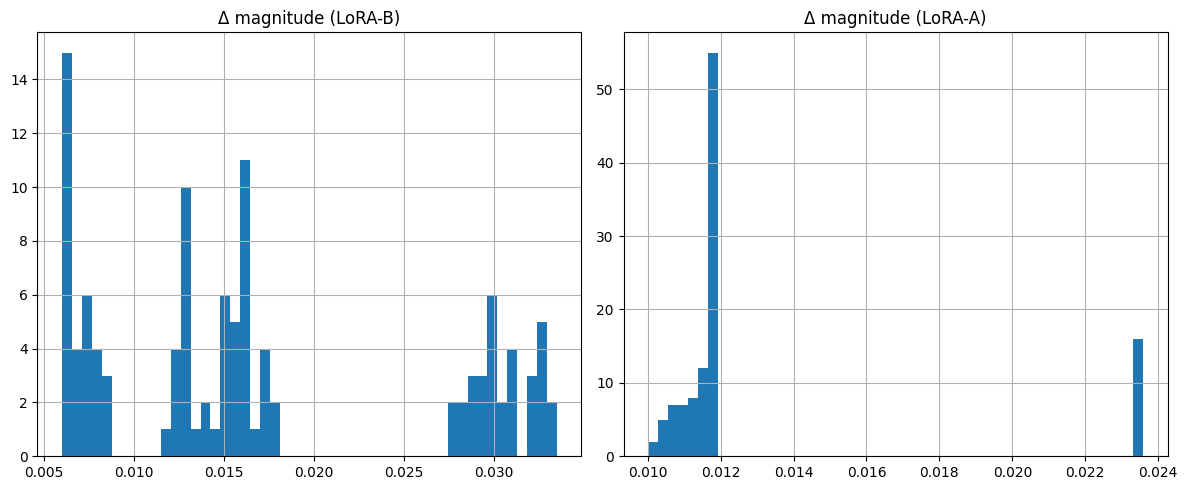

In [6]:
disable_lora_trainer, disable_peft_model, disable_train_dl, disable_eval_dl = initialize_model(seed=SEED)

disable_peft_model.eval()

disable_initial_weights = extract_lora_weights(disable_peft_model)
np.save("disable_initial_weights.npy", disable_initial_weights)

disable_initial_metrics = metric_fn(disable_peft_model, disable_eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
print(f"Final perplexity after extended training: {disable_initial_metrics['perplexity']:.2f}")

limited_batches = get_limited_batches(disable_train_dl, 5)

disable_lora_trainer.train(limited_batches, fhe="disable", device=DEVICE)

disable_finetuned_weights = extract_lora_weights(disable_peft_model)

disable_losses = disable_lora_trainer.get_training_losses()

np.save("disable_initial_weights.npy", disable_initial_weights)
np.save("disable_finetuned_weights.npy", disable_finetuned_weights)
np.save("disable_losses.npy", disable_losses)


disable_df = collect_stats(disable_initial_weights, disable_finetuned_weights)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disable_df.query("part=='B'")["L2"].hist(bins=50, ax=axes[0])
axes[0].set_title("Δ magnitude (LoRA-B)")

disable_df.query("part=='A'")["L2"].hist(bins=50, ax=axes[1])
axes[1].set_title("Δ magnitude (LoRA-A)")

plt.tight_layout()
plt.show()

# Remote mode

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
2025-07-17 02:25:40,818 - INFO - === Starting new training session ===
2025-07-17 02:25:40,821 - INFO - Processing '5' Remote Modules.
2025-07-17 02:25:40,821 - INFO - Benchmark file already created: '/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/client_benchmarks.csv'


Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`

LoRA layers detected in the model.


Compiling FHE layers: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]
2025-07-17 02:25:44,600 - INFO - Compilation complete.


Compilation completed under: 3.78s using DEVICE='cpu'
Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`



Final perplexity after extended training: 116.61


2025-07-17 02:26:03,852 - INFO - Model saved at compiled_models/meta-llama
2025-07-17 02:26:04,343 - INFO - Generating keys...
2025-07-17 02:26:04,990 - INFO - Keys generated...
2025-07-17 02:26:05,010 - INFO - Saving the public evaluation key at compiled_models/meta-llama/client/public_evaluation_key.serverKey...
2025-07-17 02:27:01,553 - INFO - The key has been sent to the server...
2025-07-17 02:27:01,555 - INFO - All remote modules initialized.
Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]2025-07-17 02:27:34,232 - INFO - Step 1: loss=2.453567, avg_loss=2.453567
2025-07-17 02:27:34,236 - INFO - Average gradient magnitude: 1.122485
Epoch 1:  20%|██        | 1/5 [00:32<02:10, 32.68s/it, loss=2.4536]2025-07-17 02:28:06,671 - INFO - Step 2: loss=3.985708, avg_loss=3.219637
2025-07-17 02:28:06,675 - INFO - Average gradient magnitude: 1.585597
Epoch 1:  40%|████      | 2/5 [01:05<01:37, 32.54s/it, loss=3.9857]2025-07-17 02:28:39,036 - INFO - Step 3: loss=4.814536, avg_loss=3.751270
2025-

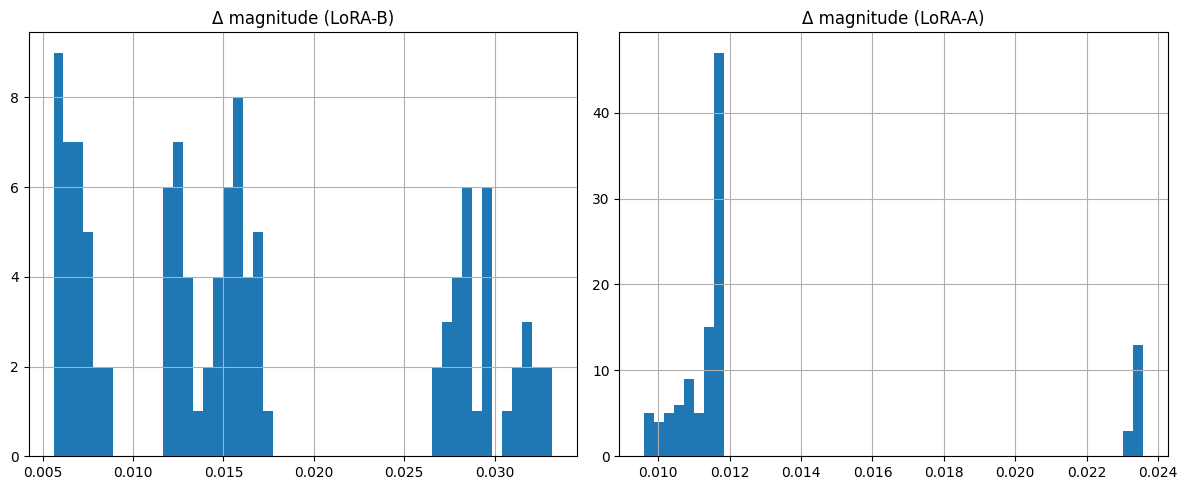

In [22]:
remote_lora_trainer, remote_peft_model, remote_train_dl, remote_eval_dl = initialize_model(seed=SEED)

remote_peft_model.eval()

remote_initial_weights = extract_lora_weights(remote_peft_model)

remote_initial_metrics = metric_fn(remote_peft_model, remote_eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
print(f"Final perplexity after extended training: {remote_initial_metrics['perplexity']:.2f}")

limited_batches = get_limited_batches(remote_train_dl, 5)

remote_lora_trainer.save_and_clear_private_info(COMPILED_MODELS_PATH, via_mlir=True)

client_path = COMPILED_MODELS_PATH / "client"

remote_lora_trainer.hybrid_model.init_client(
    path_to_clients=client_path, path_to_keys=PATH_TO_CLIENTS_KEYS
)

# Enable remote FHE mode: linear layers will be executed on the server
remote_lora_trainer.hybrid_model.set_fhe_mode(HybridFHEMode.REMOTE)

remote_lora_trainer.train(limited_batches, fhe="remote", device=DEVICE)
remote_losses = remote_lora_trainer.get_training_losses()
remote_finetuned_weights = extract_lora_weights(remote_peft_model)

np.save("remote_initial_weights.npy", remote_initial_weights)
np.save("remote_finetuned_weights.npy", remote_finetuned_weights)
np.save("remote_losses.npy", remote_losses)

remote_df = collect_stats(remote_initial_weights, remote_finetuned_weights)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

remote_df.query("part=='B'")["L2"].hist(bins=50, ax=axes[0])
axes[0].set_title("Δ magnitude (LoRA-B)")

remote_df.query("part=='A'")["L2"].hist(bins=50, ax=axes[1])
axes[1].set_title("Δ magnitude (LoRA-A)")

plt.tight_layout()
plt.show()

## Execute mode

In [10]:
execute_lora_trainer, execute_peft_model, execute_train_dl, execute_eval_dl = initialize_model(seed=SEED)

execute_peft_model.eval()

execute_initial_weights = extract_lora_weights(execute_peft_model)
np.save("execute_initial_weights.npy", execute_initial_weights)

execute_initial_metrics = metric_fn(execute_peft_model, execute_eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
print(f"Final perplexity after extended training: {execute_initial_metrics['perplexity']:.2f}")

limited_batches = get_limited_batches(execute_train_dl, 5)

execute_lora_trainer.train(limited_batches, fhe="execute", device=DEVICE)

execute_finetuned_weights = extract_lora_weights(execute_peft_model)

execute_losses = execute_lora_trainer.get_training_losses()

np.save("execute_initial_weights.npy", execute_initial_weights)
np.save("execute_finetuned_weights.npy", execute_finetuned_weights)
np.save("execute_losses.npy", execute_losses)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
2025-07-17 02:03:38,070 - INFO - === Starting new training session ===
2025-07-17 02:03:38,074 - INFO - Processing '5' Remote Modules.
2025-07-17 02:03:38,075 - INFO - Benchmark file already created: '/Users/kcelia/Zama/concrete-ml/use_case_examples/hybrid_finetuning_of_llama/client_benchmarks.csv'


Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`

LoRA layers detected in the model.


Compiling FHE layers: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]
2025-07-17 02:03:42,918 - INFO - Compilation complete.


Compilation completed under: 4.84s using DEVICE='cpu'
Prompt: `When you multiply a number by 7, it becomes 98. What is that number?
`
Response: `A. 0
B. 1
C. 2
D. 3
E. 4
Answer: B`



Final perplexity after extended training: 116.61


FHE Modules Inference: 100%|██████████| 5/5 [01:56<00:00, 23.33s/it]
2025-07-17 02:05:52,819 - INFO - Step 1: loss=2.090029, avg_loss=2.090029
2025-07-17 02:05:52,824 - INFO - Average gradient magnitude: 1.292121
FHE Modules Inference: 100%|██████████| 5/5 [02:42<00:00, 32.44s/it]
2025-07-17 02:08:35,080 - INFO - Step 2: loss=4.273175, avg_loss=3.181602
2025-07-17 02:08:35,087 - INFO - Average gradient magnitude: 1.624507
FHE Modules Inference: 100%|██████████| 5/5 [02:29<00:00, 29.88s/it]
2025-07-17 02:11:04,532 - INFO - Step 3: loss=5.407122, avg_loss=3.923442
2025-07-17 02:11:04,537 - INFO - Average gradient magnitude: 3.217531
FHE Modules Inference: 100%|██████████| 5/5 [02:18<00:00, 27.70s/it]
2025-07-17 02:13:23,044 - INFO - Step 4: loss=0.959360, avg_loss=3.182421
2025-07-17 02:13:23,048 - INFO - Average gradient magnitude: 0.562591
FHE Modules Inference: 100%|██████████| 5/5 [02:17<00:00, 27.49s/it]
2025-07-17 02:15:40,499 - INFO - Step 5: loss=0.855362, avg_loss=2.717010
2025-

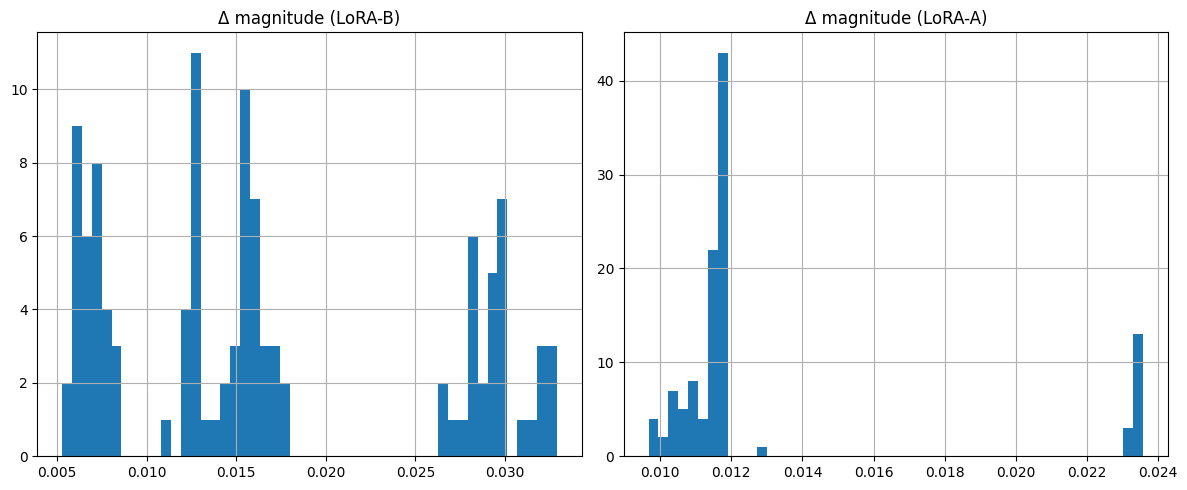

In [11]:
execute_df = collect_stats(execute_initial_weights, execute_finetuned_weights)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

execute_df.query("part=='B'")["L2"].hist(bins=50, ax=axes[0])
axes[0].set_title("Δ magnitude (LoRA-B)")

execute_df.query("part=='A'")["L2"].hist(bins=50, ax=axes[1])
axes[1].set_title("Δ magnitude (LoRA-A)")

plt.tight_layout()
plt.show()

## Loss Comparison

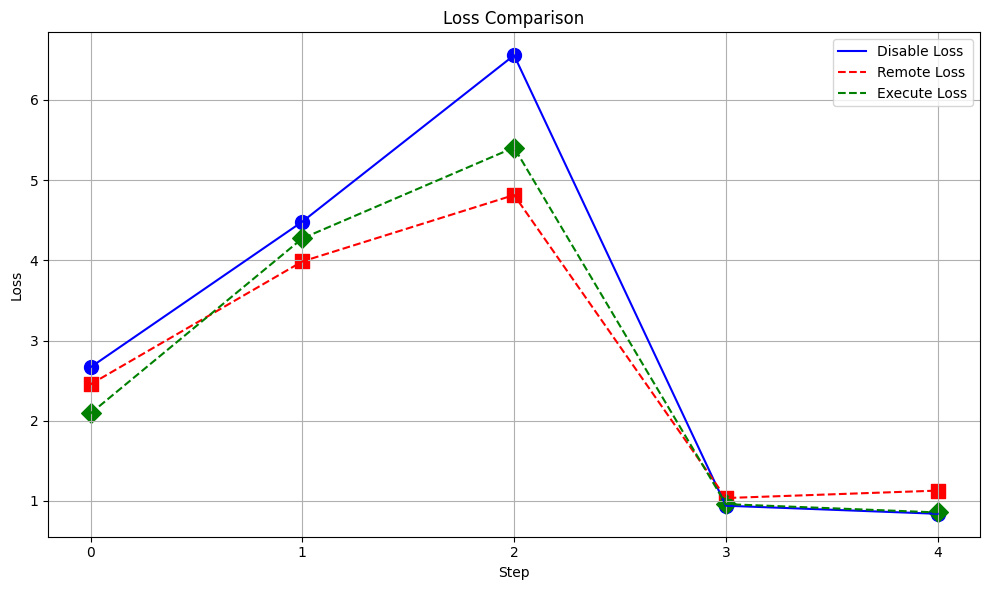

In [23]:
plt.figure(figsize=(10, 6))
steps = np.arange(len(disable_losses))

plt.plot(steps, disable_losses, label="Disable Loss", color="blue")
plt.plot(steps, remote_losses, label="Remote Loss", color="red", linestyle="--")
plt.plot(steps, execute_losses, label="Execute Loss", color="green", linestyle="--")

plt.scatter(steps, disable_losses, color="blue", s=100)
plt.scatter(steps, remote_losses, color="red", marker="s", s=100)
plt.scatter(steps, execute_losses, color="green", marker="D", s=100)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid()
plt.xticks(steps)

plt.tight_layout()
plt.show()

In [24]:
disable_losses

[2.666214942932129,
 4.482192516326904,
 6.5580010414123535,
 0.9392324686050415,
 0.8384132385253906]

In [25]:
execute_losses

[2.090029239654541,
 4.27317476272583,
 5.407121658325195,
 0.9593600630760193,
 0.8553619384765625]

In [26]:
remote_losses

[2.4535670280456543,
 3.9857075214385986,
 4.814536094665527,
 1.0349410772323608,
 1.1276791095733643]

## Compilation

In [ ]:
# inputset = get_random_inputset(
#         vocab_size=VOCAB_SIZE, batch_size=BATCH_SIZE, max_length=MAX_LENGTH, device=DEVICE
#     )
# start_time = time()
# lora_trainer.compile(inputset, n_bits=N_BITS, device=DEVICE)
# print(f"Compilation completed under: {time() - start_time:.2f}s using {DEVICE=}")

Compiling FHE layers: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]
2025-07-16 17:35:44,971 - INFO - Compilation complete.


Compilation completed under: 3.83s using DEVICE='cpu'


## Separate Remote Modules

In a hybrid execution setup, we must isolate the parts of the model that will run remotely (typically, the linear layers) from those that will stay on the client side (non-linear layers, activations, etc.).

The following line performs this separation by:

- Saving the compiled remote modules (linear layers quantized and ready for remote execution),
- Removing sensitive information such as calibration data or client-side metadata,


In [ ]:
# lora_trainer.save_and_clear_private_info(COMPILED_MODELS_PATH, via_mlir=True)

## Initialize Client-Side Model

Here we generate keys and send the public evaluation key to the server.

In [ ]:
# client_path = COMPILED_MODELS_PATH / "client"

# lora_trainer.hybrid_model.init_client(
#     path_to_clients=client_path, path_to_keys=PATH_TO_CLIENTS_KEYS
# )

# # Enable remote FHE mode: linear layers will be executed on the server
# lora_trainer.hybrid_model.set_fhe_mode(HybridFHEMode.REMOTE)

2025-07-16 12:06:38,231 - INFO - All remote modules initialized.


## Run a Short Fine-Tuning Loop with Remote FHE

We fine-tune the model for a few batches using remote FHE mode:

In [ ]:
# limited_batches = get_limited_batches(train_dl, 5)
# lora_trainer.train(limited_batches, fhe="remote", device=DEVICE)

# Evaluate the model after fine-tuning

We evaluate the model on the validation set to compute its final perplexity, a standard metric for language modeling:

In [ ]:
# finetuned_weights = extract_lora_weights(peft_model)
# peft_model.eval()
# metrics_final = metric_fn(peft_model, eval_dl, PROMPT, EVAL_RESPONSES_FILE, DEVICE)
# print(f"Final perplexity after extended training: {metrics_final['perplexity']:.2f}")

In [ ]:

# # Δ distribution LoRA-B
# df.query("part=='B'")["L2"].hist(bins=50); plt.title("Δ magnitude (LoRA-B)"); plt.show()
# df.query("part=='A'")["L2"].hist(bins=50); plt.title("Δ magnitude (LoRA-A)"); plt.show()

# # Cosine heatmap LoRA-A
# pivot = df.query("part=='A'").pivot_table(index="layer", values="cos")
# plt.imshow(pivot, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
# plt.colorbar(); plt.title("Cosine similarity LoRA-A"); plt.ylabel("Layer"); plt.show()

## Benchmark

In [10]:
!curl -o server_benchmark_matheval_llama.csv "{URL}/download_benchmark"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27259  100 27259    0     0   108k      0 --:--:-- --:--:-- --:--:--  109k


In [135]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_stats(summary_stats, title, rotation=0):
    summary_stats.T.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel("Timing (s)")
    plt.xticks(rotation=rotation)
    plt.grid(axis='y')
    plt.tight_layout()

    plt.show()

    return summary_stats

relevant_columns_stats = ["min", "50%", "max", "mean"]
rename_median = {"50%": "median"}
client = pd.read_csv("client_benchmarks.csv", sep=";")
server = pd.read_csv("server_benchmarks.csv", sep=";")

server['uid'].drop_duplicates(), client['uid'].drop_duplicates()

(0     42b441c4-506f-4a40-8f52-404500b73f93
 26    7c4a45a4-0674-4647-9276-6e70bf42d423
 52    bd22906d-14be-4c28-95bd-d37fbff39772
 Name: uid, dtype: object,
 0     42b441c4-506f-4a40-8f52-404500b73f93
 25    7c4a45a4-0674-4647-9276-6e70bf42d423
 50    bd22906d-14be-4c28-95bd-d37fbff39772
 Name: uid, dtype: object)

In [136]:
server.head(2)

,endpoint,date,device,machine,uid,layer_name,index,input_shape,remote_weight_shape,time_read_key,time_deserialization_key,time_serialization_key,time_storage_key,time_read_input,time_deserialize_input,encrypted_input_size,time_weight_quantization,time_serialization_output,time_matmul,time_packing_output_response,total_add_key_func,total_compute_func
0,Key,2025-07-17 09:21:24,cuda,g4dn.16xlarge,42b441c4-506f-4a40-8f52-404500b73f93,NaN,NaN,NaN,NaN,0.039732,0.117553,0.098201,0.246416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404454,NaN
1,compute,2025-07-17 09:21:35,cuda,g4dn.16xlarge,42b441c4-506f-4a40-8f52-404500b73f93,inference_model.base_model.model.model.layers....,0.0,"(64, 2048)","(2048, 2048)",NaN,NaN,NaN,NaN,0.000111,0.000434,530968.0,0.143631,0.000985,5.850805,0.000266,NaN,6.010688


In [137]:
client.head(2)

,date,device,machine,mode,uid,server_remote_address,layer_name,input_shape,remote_weight_shape,time_encryption_input,time_serialization_input,total_send_input_func,time_deserialization_output,time_decryption_output,time_dequantization_output,total_compute_func,total_timing
0,2025-07-17 11:21:36,mps:0,M4,Remote,42b441c4-506f-4a40-8f52-404500b73f93,http://15.237.83.254:8001,remote_weights_layer0.npy,"(64, 2048)","(2048, 2048)",0.020803,0.000564,NaN,0.000943,0.018788,0.019075,6.948918,10.531241
1,2025-07-17 11:21:40,mps:0,M4,Remote,42b441c4-506f-4a40-8f52-404500b73f93,http://15.237.83.254:8001,remote_weights_layer1.npy,"(64, 2048)","(2048, 512)",0.020593,0.000123,NaN,0.000231,0.019058,0.010594,3.880728,4.500235


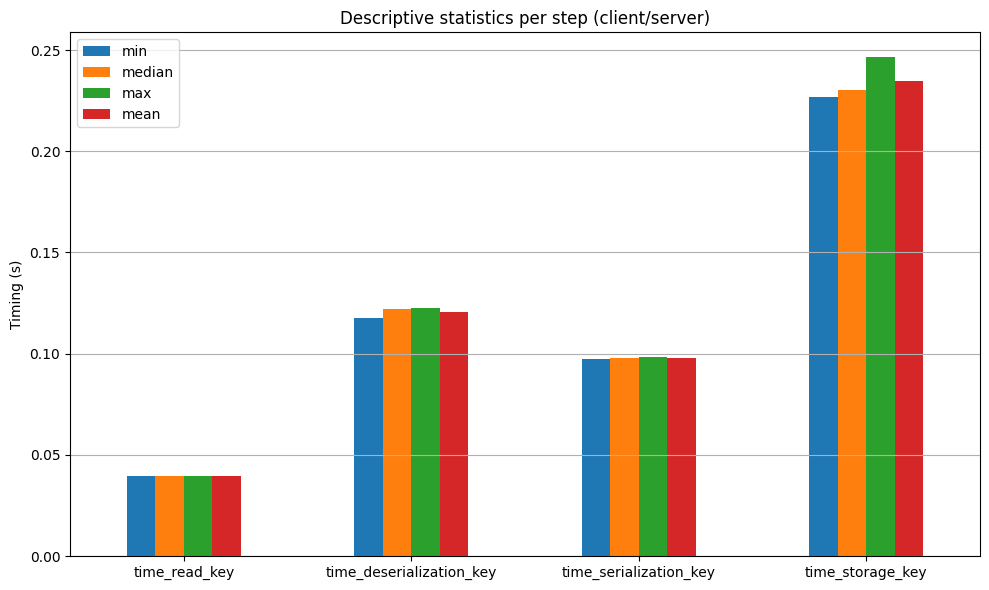

,time_read_key,time_deserialization_key,time_serialization_key,time_storage_key
min,0.039582,0.117553,0.097448,0.226790
median,0.039721,0.122092,0.097661,0.230222
max,0.039732,0.122666,0.098201,0.246416
mean,0.039678,0.120770,0.097770,0.234476


In [138]:
# Timing for the key is seconds

server_key_stats = server[["time_read_key", "time_deserialization_key", "time_serialization_key", "time_storage_key"]].dropna().describe()
summary_key_stats = server_key_stats.loc[relevant_columns_stats].rename(index=rename_median)

plot_stats(summary_key_stats, "Descriptive statistics per step (client/server)")

In [139]:
# Consider the worst case for large inputs

largest_input_shape = "(64, 2048)"
largest_remote_weight_shape = "(2048, 2048)"

server_wc = server[(server['remote_weight_shape'] == largest_remote_weight_shape) & (server['input_shape'] == largest_input_shape)]
client_wc = client[(client['remote_weight_shape'] == largest_remote_weight_shape) & (client['input_shape'] == largest_input_shape)]

### Timing for input in seconds

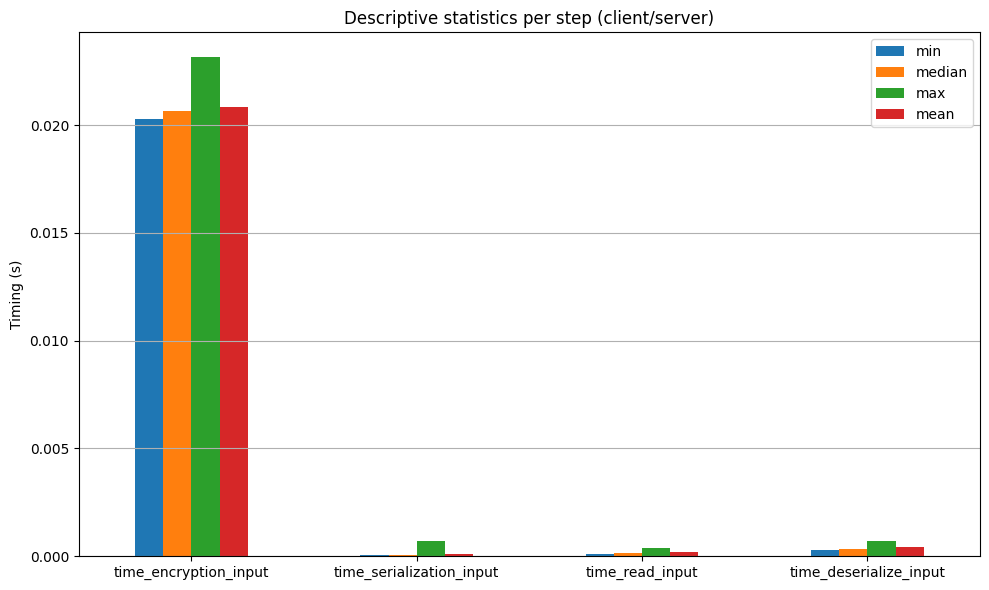

,time_encryption_input,time_serialization_input,time_read_input,time_deserialize_input
min,0.020272,0.000044,0.000096,0.000269
median,0.020672,0.000058,0.000156,0.000327
max,0.023154,0.000696,0.000388,0.000700
mean,0.020833,0.000100,0.000211,0.000413


In [140]:
# In the client side, we encrypt, serialize the input and send it to the server
client_stats = client_wc[['time_encryption_input', 'time_serialization_input']].dropna().describe()
# In the server side, we read the input, deserialize it
# <!> I dont have the time_read_input anymore because the input is not stored on the server side, to avoid memory issues
# <!> Note: The 'time_read_input' and 'total_send_input_func' metrics are no longer available because
# the input data is not stored on the server side in order to reduce memory usage.
# Hence, the endpoints /send_data and /compute are combined

server_stats = server_wc[['time_read_input', 'time_deserialize_input']].dropna().describe()

combined_input_stats = pd.concat([client_stats, server_stats], axis=1)

summary_stats = combined_input_stats.loc[relevant_columns_stats].rename(index=rename_median)

plot_stats(summary_stats, "Descriptive statistics per step (client/server)")

### Timing for output in seconds

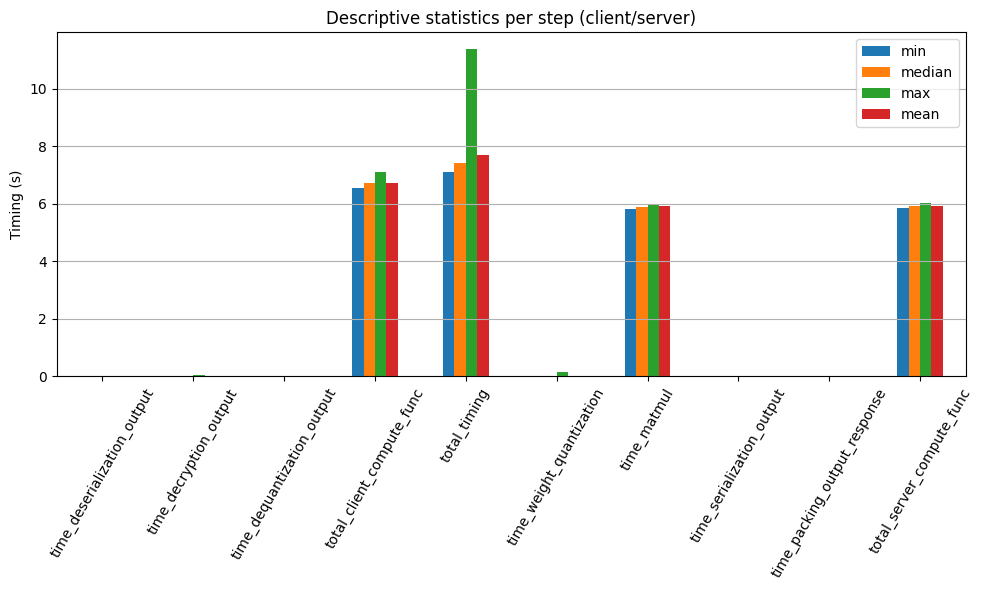

,time_deserialization_output,time_decryption_output,time_dequantization_output,total_client_compute_func,total_timing,time_weight_quantization,time_matmul,time_serialization_output,time_packing_output_response,total_server_compute_func
min,0.000094,0.015400,0.000735,6.528906,7.098038,0.007512,5.824324,0.000245,0.000030,5.846116
median,0.000162,0.020224,0.000909,6.703827,7.428466,0.007777,5.889600,0.000662,0.000033,5.914353
max,0.000943,0.026284,0.019075,7.100147,11.387622,0.143631,5.980948,0.000985,0.000266,6.010688
mean,0.000229,0.020106,0.001388,6.720846,7.703829,0.010832,5.904840,0.000528,0.000070,5.930627


In [141]:
client_stats = client_wc[['time_deserialization_output', 'time_decryption_output', 'time_dequantization_output', 'total_compute_func', 'total_timing']].describe()
client_stats = client_stats.loc[relevant_columns_stats].rename(index=rename_median).rename(columns={"total_compute_func": "total_client_compute_func"})

server_stats = server_wc[['time_weight_quantization', 'time_matmul', 'time_serialization_output', 'time_packing_output_response', 'total_compute_func']].describe()
server_stats = server_stats.loc[relevant_columns_stats].rename(index=rename_median).rename(columns={"total_compute_func": "total_server_compute_func"})

combined_output_stats = pd.concat([client_stats, server_stats], axis=1)

plot_stats(combined_output_stats, "Descriptive statistics per step (client/server)", rotation=60)


In [142]:
# Network Latency
# timing-client(endpoint/compute) -  timing-server(endpoint/compute)

combined_output_stats["diff_compute_endpoint"] = (
    combined_output_stats["total_client_compute_func"]
    - combined_output_stats["total_server_compute_func"]
)

combined_output_stats[['total_client_compute_func', 'total_server_compute_func', 'diff_compute_endpoint']]

,total_client_compute_func,total_server_compute_func,diff_compute_endpoint
min,6.528906,5.846116,0.682790
median,6.703827,5.914353,0.789474
max,7.100147,6.010688,1.089459
mean,6.720846,5.930627,0.790219


In [143]:
# Network Latency

# timing-client(forward) -  timing-server(endpoint/compute/real_matmul)

# In the client forward, we include the timing of the :
# - input encryption/serialization/transmission +
# - all server operations +
# - output deserialization/decryption/dequantization

combined_output_stats["diff_total_timing_minus_real_matmul_timing"] = (
    combined_output_stats["total_timing"]
    - combined_output_stats["time_matmul"]
)

combined_output_stats[['total_timing', 'time_matmul', 'diff_total_timing_minus_real_matmul_timing']]

,total_timing,time_matmul,diff_total_timing_minus_real_matmul_timing
min,7.098038,5.824324,1.273714
median,7.428466,5.889600,1.538866
max,11.387622,5.980948,5.406674
mean,7.703829,5.904840,1.798989


The HybridFHEModel enables efficient encrypted fine-tuning and inference by preserving data privacy while minimizing the computational burden on the client side.